In [61]:
## personal imports
from processor.processor import Processor as p
from database.market import Market
from database.adatabase import ADatabase
from datetime import datetime
from fund.fund import Fund
from pricer.pricer import Pricer as pricer_list
from ranker.ranker import Ranker as ranker_list
from classifier.classifier import Classifier as classifier_list
from portfolio.aportfolio import APortfolio

from analysis.quarterly_analysis import QuarterlyAnalysis as quarterly_analysis
from analysis.weekly_analysis import WeeklyAnalysis as weekly_analysis

## risk and return class imports
from returns.products import Products as returns_products_class

from fund.fund import Fund
## standard imports
from statistics import variance
import math
from datetime import datetime, timedelta
import pytz
import pandas as pd
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import pickle

In [62]:
backtest_start_date = datetime(2016,1,1)
backtest_end_date  = datetime(2023,1,1)
current_start_date = datetime(2023,1,1)

In [63]:
market = Market()

In [64]:
portfolio = APortfolio(pricer_list.QUARTERLY_STOCK_FINANCIAL
                       ,classifier_list.QUARTERLY_STOCK_FINANCIAL_CLASSIFIER
                       ,ranker_list.QUARTERLY_STOCK_EARNINGS_RANKER)
portfolio_ii = APortfolio(pricer_list.WEEKLY_STOCK_SPECULATION
                          ,classifier_list.WEEKLY_STOCK_SPECULATION_CLASSIFIER
                          ,ranker_list.WEEKLY_STOCK_ROLLING_RANKER)
portfolio_iii = APortfolio(pricer_list.WEEKLY_STOCK_ROLLING
                           ,classifier_list.WEEKLY_STOCK_SPECULATION_CLASSIFIER
                          ,ranker_list.WEEKLY_STOCK_ROLLING_RANKER)
portfolio_iv = APortfolio(pricer_list.WEEKLY_STOCK_WINDOW
                          ,classifier_list.WEEKLY_STOCK_SPECULATION_CLASSIFIER
                          ,ranker_list.WEEKLY_STOCK_ROLLING_RANKER)
portfolios = []
# portfolios.append(portfolio)
portfolios.append(portfolio_ii)
portfolios.append(portfolio_iii)
portfolios.append(portfolio_iv)
fund = Fund(portfolios,backtest_start_date,backtest_end_date,current_start_date)
fund.initialize_portfolios()

In [65]:
market.connect()
sp500 = market.retrieve("sp500")
market.disconnect()
sp500 = sp500.rename(columns={"Symbol":"ticker"})

In [66]:
tyields = returns_products_class.tyields()
bench_returns = returns_products_class.spy_bench()

In [67]:
trades = []
for portfolio in fund.portfolios:
    portfolio.db.connect()
    trade = portfolio.db.retrieve("historical_trades")
    trade["positions"] = portfolio.pricer_class.positions
    trade["portfolio"] = portfolio.name
    trade["pricer_timeframe"] = portfolio.pricer_class.time_horizon_class.naming_convention
    trades.append(trade)
    portfolio.db.disconnect()

In [68]:
t = pd.concat(trades)
t = t[t["year"]>=backtest_start_date.year]

In [69]:
t

,year,week,ticker,weekly_delta,weekly_delta_sign,short_returns,returns,position,actual_returns,value,ceiling,classification,rank,short,market_return,buy_day,sell_day,positions,portfolio,pricer_timeframe
0,2016.0,5.0,PKG,0.042472,1.0,0.988826,0.985689,0.0,0.985689,True,True,True,False,False,1.15,0.0,1.0,20,wss_wssc_wsrr_b_r,week
1,2016.0,8.0,FCX,0.132181,1.0,0.950000,0.952081,0.0,0.952081,True,True,True,False,False,1.15,0.0,1.0,20,wss_wssc_wsrr_b_r,week
2,2016.0,9.0,ECL,0.018412,1.0,1.030717,1.009751,0.0,1.009751,True,True,True,False,False,1.15,0.0,1.0,20,wss_wssc_wsrr_b_r,week
3,2016.0,10.0,ENPH,0.061261,1.0,0.950000,0.996970,0.0,0.996970,True,True,True,False,False,1.15,0.0,1.0,20,wss_wssc_wsrr_b_r,week
4,2016.0,11.0,FTNT,0.083447,1.0,1.037130,0.997858,0.0,0.997858,True,True,True,False,False,1.15,0.0,1.0,20,wss_wssc_wsrr_b_r,week
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
437775,2022.0,48.0,IT,0.168430,1.0,0.980795,0.983948,19.0,0.983948,True,False,False,False,False,1.15,4.0,3.0,20,wsr_wssc_wsrr_b_r,week
437776,2022.0,49.0,SBUX,0.145280,1.0,0.994302,1.005207,19.0,1.005207,True,False,False,False,False,1.15,4.0,3.0,20,wsr_wssc_wsrr_b_r,week
437777,2022.0,50.0,SPG,0.114068,1.0,0.992779,1.005846,19.0,1.005846,True,False,False,False,False,1.15,4.0,3.0,20,wsr_wssc_wsrr_b_r,week
437778,2022.0,51.0,DD,0.107677,1.0,0.990106,0.989379,19.0,0.989379,True,False,False,False,False,1.15,4.0,3.0,20,wsr_wssc_wsrr_b_r,week


In [70]:
nonindex_columns = [
"year"
,"quarter"
,"week"
,"ticker"
,"quarterly_delta_sign"
,"quarterly_delta"
,"weekly_delta_sign"
,"weekly_delta"
,"short_returns"
,"returns"
,"floored_returns"
,"actual_returns"
,"position"
,"projected_quarterly_return"
,"positions"] 

In [71]:
indexers = []
indexer = []
for col in t.columns:
    if col not in nonindex_columns:
        indexers.append(list(t[col].unique()))
        indexer.append(col)
stuff = t[indexer].to_dict("records")
parameters = [dict(t) for t in {tuple(d.items()) for d in stuff}]

In [72]:
indexer

['value',
 'ceiling',
 'classification',
 'rank',
 'short',
 'market_return',
 'buy_day',
 'sell_day',
 'portfolio',
 'pricer_timeframe']

In [73]:
analysis = []
for parameter in parameters:
    try:
        ledger = t.sort_values(["year",parameter["pricer_timeframe"]]).copy()
        for key in parameter.keys():
            ledger = ledger[ledger[key]==parameter[key]]
        positions = int(int(ledger["positions"].mean()))
        anas = weekly_analysis if parameter["pricer_timeframe"] == "week" else quarterly_analysis
        if ledger.index.size > 0:
            cumulative = anas.trade_analysis(indexer,ledger,positions,parameter,tyields,bench_returns)
            analysis.append(cumulative[indexer + ["pv","beta","rrr","sharpe"]].iloc[-1])
    except Exception as e:
        print(str(e))
        continue
a = pd.DataFrame(analysis)

In [92]:
a.sort_values("pv",ascending=False).head(20)

,value,ceiling,classification,rank,short,market_return,buy_day,sell_day,portfolio,pricer_timeframe,pv,beta,rrr,sharpe
334,True,True,False,False,False,1.15,1.0,5.0,wsr_wssc_wsrr_b_r,week,4.370380,0.061862,1.063599,54.467000
334,True,False,False,False,False,1.15,1.0,5.0,wsr_wssc_wsrr_b_r,week,4.370380,0.061862,1.063599,54.467000
334,True,True,False,False,False,1.15,1.0,5.0,wss_wssc_wsrr_b_r,week,4.060321,0.036496,1.037914,83.827748
334,True,False,False,False,False,1.15,1.0,5.0,wss_wssc_wsrr_b_r,week,4.060321,0.036496,1.037914,83.827748
332,True,True,False,False,False,1.15,2.0,5.0,wsr_wssc_wsrr_b_r,week,3.158433,0.081188,1.083167,26.573923
332,True,False,False,False,False,1.15,2.0,5.0,wsr_wssc_wsrr_b_r,week,3.158433,0.081188,1.083167,26.573923
328,True,True,False,False,False,1.15,3.0,4.0,wsr_wssc_wsrr_b_r,week,3.102283,0.114894,1.117297,18.289211
328,True,False,False,False,False,1.15,3.0,4.0,wsr_wssc_wsrr_b_r,week,3.102283,0.114894,1.117297,18.289211
328,True,False,False,False,False,1.15,3.0,3.0,wsr_wssc_wsrr_b_r,week,2.946953,0.113125,1.115506,17.202111
328,True,True,False,False,False,1.15,3.0,3.0,wsr_wssc_wsrr_b_r,week,2.946953,0.113125,1.115506,17.202111


In [75]:
a.sort_values("pv",ascending=False).groupby("portfolio").nth(0).reset_index()

,portfolio,value,ceiling,classification,rank,short,market_return,buy_day,sell_day,pricer_timeframe,pv,beta,rrr,sharpe
0,wsr_wssc_wsrr_b_r,True,True,False,False,False,1.15,1.0,5.0,week,4.370380,0.061862,1.063599,54.467000
1,wss_wssc_wsrr_b_r,True,True,False,False,False,1.15,1.0,5.0,week,4.060321,0.036496,1.037914,83.827748


In [76]:
top = a[a["portfolio"]=="wss_wssc_wsrr_b_r"].sort_values("pv",ascending=False).iloc[0]
anas = weekly_analysis if top["pricer_timeframe"] == "week" else quarterly_analysis
analysis = t
for key in parameter.keys():
    analysis = analysis[(analysis[key]==top[key])]
naming = top["pricer_timeframe"]
ledger = analysis[["year",naming,"ticker",f"{naming}ly_delta",f"{naming}ly_delta_sign","actual_returns","position"]]
ledger = ledger[ledger["year"]>=backtest_start_date.year]
ledger = ledger.merge(sp500[["ticker","GICS Sector","Security"]],on="ticker",how="left")

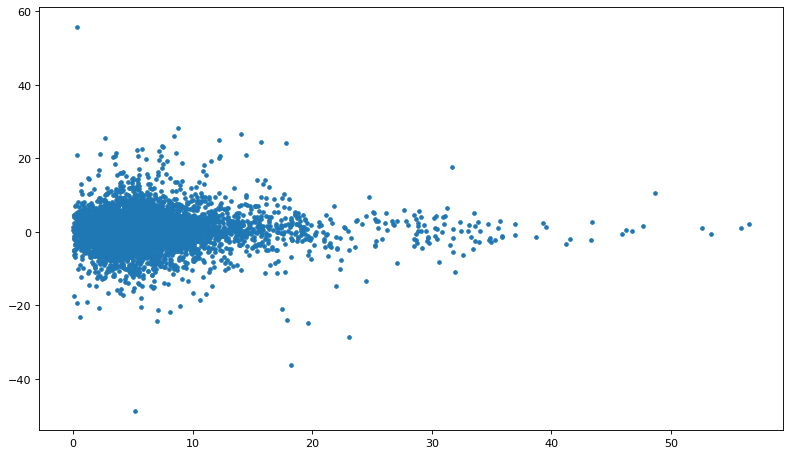

In [77]:
plt.figure(figsize=(12, 7), dpi=80)
plt.scatter(ledger[f"{naming}ly_delta"] * 100, (ledger["actual_returns"]-1)*100,s=10)

In [78]:
ledger.sort_values(["year",naming,"position"],ascending=True).head(20)

,year,week,ticker,weekly_delta,weekly_delta_sign,actual_returns,position,GICS Sector,Security
0,2016.0,5.0,PKG,0.045851,1.0,0.983971,0.0,Materials,Packaging Corporation of America
335,2016.0,5.0,BSX,0.035099,1.0,0.920404,1.0,Health Care,Boston Scientific
669,2016.0,5.0,ED,0.030547,1.0,1.028121,2.0,Utilities,Consolidated Edison
1003,2016.0,5.0,CPB,0.028963,1.0,0.990055,3.0,Consumer Staples,Campbell Soup Company
1336,2016.0,5.0,WBA,0.015146,1.0,0.930128,4.0,Consumer Staples,Walgreens Boots Alliance
1669,2016.0,5.0,IPGP,0.009664,1.0,1.005504,5.0,Information Technology,IPG Photonics
2001,2016.0,5.0,IP,0.002629,1.0,1.004430,6.0,Materials,International Paper
2333,2016.0,5.0,LMT,0.000062,1.0,1.012687,7.0,Industrials,Lockheed Martin
1,2016.0,6.0,NVR,0.140525,1.0,1.002497,0.0,Consumer Discretionary,"NVR, Inc."
336,2016.0,6.0,CTRA,0.076481,1.0,0.990812,1.0,Energy,Coterra


In [79]:
ledger["actual_returns"].mean()

1.0046777257268804

In [80]:
ledger[ledger["actual_returns"]>1].index.size / ledger.index.size

0.5643730886850153

In [81]:
portfolio = ledger.pivot_table(index=["year",naming],columns="position",values="actual_returns").fillna(1).reset_index()

In [82]:
portfolio

position,year,week,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,...,10.0,11.0,12.0,13.0,14.0,15.0,16.0,17.0,18.0,19.0
0,2016.0,5.0,0.983971,0.920404,1.028121,0.990055,0.930128,1.005504,1.004430,1.012687,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,2016.0,6.0,1.002497,0.990812,1.030646,1.005184,0.987013,1.070792,1.044011,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
2,2016.0,7.0,1.020213,1.026971,1.074700,1.028925,1.027281,1.049830,0.999331,1.027090,...,1.035745,1.011002,1.057152,1.037550,1.024836,1.019772,1.084071,1.026144,1.023296,1.024666
3,2016.0,8.0,1.060264,1.096157,1.017196,0.904153,1.097132,1.007412,1.029564,1.022664,...,0.979036,1.103378,1.040419,1.031398,1.037900,1.045155,1.043288,1.045217,1.012702,1.011555
4,2016.0,9.0,1.207474,1.010759,0.990802,0.985732,0.964912,1.045776,1.070028,0.982606,...,1.012186,1.014230,1.102234,0.994374,0.996715,1.079667,0.991913,1.032728,0.984499,1.017850
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
330,2022.0,48.0,1.025194,1.020266,1.023254,1.077363,1.019837,1.000238,1.070744,1.009057,...,0.982724,0.980320,0.995827,1.069413,0.990967,0.994872,0.995464,1.015807,0.874934,0.938804
331,2022.0,49.0,1.074152,1.025274,1.003756,1.053075,1.035117,1.032258,1.071618,1.025406,...,0.992534,1.017908,1.070189,1.071064,1.067389,1.018154,1.012105,1.048291,0.990854,0.994428
332,2022.0,50.0,0.981685,0.901328,0.850155,0.915374,0.888889,0.970258,0.957580,0.905312,...,1.001599,0.970531,0.958697,0.951620,0.963843,0.931806,0.956978,0.930066,0.962419,0.944350
333,2022.0,51.0,1.053135,1.021221,1.040711,0.996837,1.005470,1.001853,1.030327,1.011855,...,1.020225,1.011805,1.032020,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [83]:
cumulative = anas.iteration_analysis(portfolio,positions,bench_returns)

In [84]:
cumulative

,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,...,17.0,18.0,19.0,year,week,pv,adjclose,bench,date_string,date
0,0.983971,0.920404,1.028121,0.990055,0.930128,1.005504,1.004430,1.012687,1.000000,1.000000,...,1.000000,1.000000,1.000000,2016.0,5.0,0.993765,189.76016,1.000000,2016-W5,2016-02-05
1,0.986428,0.911947,1.059629,0.995188,0.918049,1.076686,1.048636,1.012687,1.000000,1.000000,...,1.000000,1.000000,1.000000,2016.0,6.0,1.000462,190.93200,1.006175,2016-W6,2016-02-12
2,1.006367,0.936543,1.138784,1.023974,0.943094,1.130337,1.047935,1.040121,1.072633,1.019420,...,1.026144,1.023296,1.024666,2016.0,7.0,1.035172,185.12200,0.975558,2016-W7,2016-02-19
3,1.067014,1.026598,1.158367,0.925829,1.034698,1.138714,1.078917,1.063694,1.123719,1.022367,...,1.072543,1.036294,1.036506,2016.0,8.0,1.067266,191.68750,1.010157,2016-W8,2016-02-26
4,1.288392,1.037643,1.147712,0.912620,0.998393,1.190841,1.154471,1.045193,1.090774,1.079781,...,1.107645,1.020230,1.055007,2016.0,9.0,1.094784,194.18584,1.023322,2016-W9,2016-03-04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
330,0.665859,1.600956,2.443666,2.192045,8.176182,2.134932,3.028787,4.420910,3.311334,1.961876,...,2.656663,4.075692,2.788017,2022.0,48.0,4.123615,399.81000,2.106923,2022-W48,2022-12-02
331,0.715234,1.641418,2.452844,2.308387,8.463302,2.203801,3.245703,4.533226,3.357922,2.192927,...,2.784955,4.038414,2.772483,2022.0,49.0,4.262760,402.62200,2.121741,2022-W49,2022-12-09
332,0.702134,1.479457,2.085297,2.113038,7.522935,2.138255,3.108021,4.103982,3.234894,1.924218,...,2.590191,3.886646,2.618195,2022.0,50.0,4.012966,395.22000,2.082734,2022-W50,2022-12-16
333,0.739442,1.510852,2.170191,2.106355,7.564088,2.142218,3.202279,4.152637,3.296359,2.018508,...,2.590191,3.886646,2.618195,2022.0,51.0,4.048716,394.64400,2.079699,2022-W51,2022-12-23


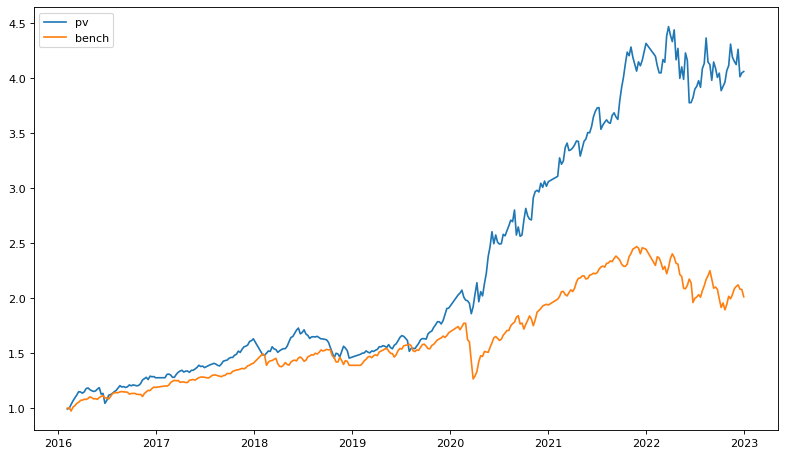

In [85]:
plt.figure(figsize=(12, 7), dpi=80)
plt.plot(cumulative["date"],cumulative["pv"])
plt.plot(cumulative["date"],cumulative["bench"])
plt.legend(["pv","bench"])

In [86]:
cumulative

,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,...,17.0,18.0,19.0,year,week,pv,adjclose,bench,date_string,date
0,0.983971,0.920404,1.028121,0.990055,0.930128,1.005504,1.004430,1.012687,1.000000,1.000000,...,1.000000,1.000000,1.000000,2016.0,5.0,0.993765,189.76016,1.000000,2016-W5,2016-02-05
1,0.986428,0.911947,1.059629,0.995188,0.918049,1.076686,1.048636,1.012687,1.000000,1.000000,...,1.000000,1.000000,1.000000,2016.0,6.0,1.000462,190.93200,1.006175,2016-W6,2016-02-12
2,1.006367,0.936543,1.138784,1.023974,0.943094,1.130337,1.047935,1.040121,1.072633,1.019420,...,1.026144,1.023296,1.024666,2016.0,7.0,1.035172,185.12200,0.975558,2016-W7,2016-02-19
3,1.067014,1.026598,1.158367,0.925829,1.034698,1.138714,1.078917,1.063694,1.123719,1.022367,...,1.072543,1.036294,1.036506,2016.0,8.0,1.067266,191.68750,1.010157,2016-W8,2016-02-26
4,1.288392,1.037643,1.147712,0.912620,0.998393,1.190841,1.154471,1.045193,1.090774,1.079781,...,1.107645,1.020230,1.055007,2016.0,9.0,1.094784,194.18584,1.023322,2016-W9,2016-03-04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
330,0.665859,1.600956,2.443666,2.192045,8.176182,2.134932,3.028787,4.420910,3.311334,1.961876,...,2.656663,4.075692,2.788017,2022.0,48.0,4.123615,399.81000,2.106923,2022-W48,2022-12-02
331,0.715234,1.641418,2.452844,2.308387,8.463302,2.203801,3.245703,4.533226,3.357922,2.192927,...,2.784955,4.038414,2.772483,2022.0,49.0,4.262760,402.62200,2.121741,2022-W49,2022-12-09
332,0.702134,1.479457,2.085297,2.113038,7.522935,2.138255,3.108021,4.103982,3.234894,1.924218,...,2.590191,3.886646,2.618195,2022.0,50.0,4.012966,395.22000,2.082734,2022-W50,2022-12-16
333,0.739442,1.510852,2.170191,2.106355,7.564088,2.142218,3.202279,4.152637,3.296359,2.018508,...,2.590191,3.886646,2.618195,2022.0,51.0,4.048716,394.64400,2.079699,2022-W51,2022-12-23


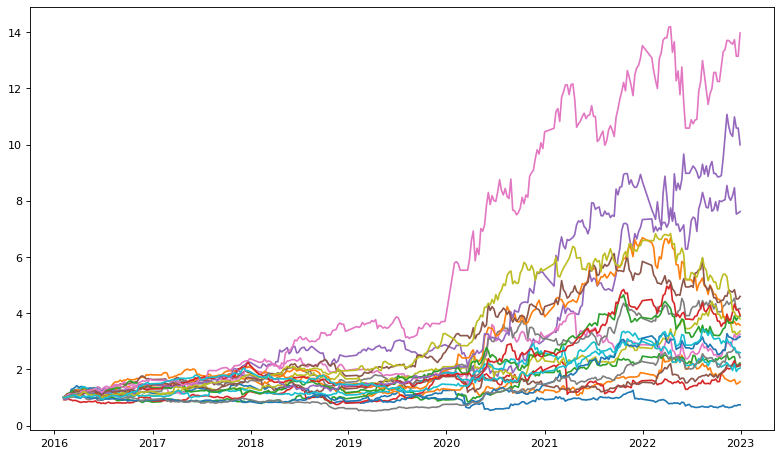

In [87]:
plt.figure(figsize=(12, 7), dpi=80)
position_columns = [x for x in cumulative.columns if x not in ["year","week","quarter","date_string","date","pv","adjclose","bench"]]
for i in position_columns:
    position = cumulative[i]
    plt.plot(cumulative["date"],position)

plt.show()


In [88]:
ledger.groupby(["GICS Sector"]).mean().sort_values("actual_returns",ascending=False)

,year,week,weekly_delta,weekly_delta_sign,actual_returns,position
GICS Sector,,,,,,
Energy,2019.197917,28.995833,0.061418,1.0,1.006532,8.868750
Information Technology,2018.912249,28.193784,0.056518,1.0,1.006177,9.931444
Communication Services,2018.936869,29.848485,0.054266,1.0,1.006084,9.262626
Health Care,2019.056320,28.942428,0.055147,1.0,1.005581,9.261577
Materials,2018.988539,28.220630,0.055590,1.0,1.005158,9.687679
Consumer Discretionary,2018.918569,29.164384,0.091771,1.0,1.004663,6.948250
Financials,2019.150171,29.165529,0.050197,1.0,1.003618,10.872014
Industrials,2019.026946,28.002994,0.047835,1.0,1.003330,10.934132
Real Estate,2018.623729,28.071186,0.041445,1.0,1.003128,10.918644


In [89]:
ledger.groupby(["year",naming,"ticker","Security"]).prod().sort_values("actual_returns",ascending=False).head(30)

weekly_delta  \
year   week ticker Security                                      
2020.0 5.0  TSLA   Tesla, Inc.                        0.003217   
2018.0 44.0 ENPH   Enphase                            0.087856   
2020.0 21.0 PENN   Penn National Gaming               0.140409   
2022.0 11.0 EPAM   EPAM Systems                       0.084177   
2020.0 35.0 CRM    Salesforce                         0.026422   
       20.0 PENN   Penn National Gaming               0.122029   
       21.0 CZR    Caesars Entertainment              0.157287   
       35.0 TSLA   Tesla, Inc.                        0.177993   
       23.0 DVN    Devon Energy                       0.074319   
            HAL    Halliburton                        0.075408   
2022.0 45.0 ETSY   Etsy                               0.057630   
2018.0 19.0 SEDG   SolarEdge                          0.053557   
2021.0 6.0  TWTR   Twitter Inc.                       0.071931   
2017.0 31.0 SEDG   SolarEdge                          0.036300   
2020.0 40.0 ENPH   Enphase                            0.086309   
2022.0 17.0 WDC    Western Digital                    0.022760   
2020.0 5.0  PENN   Penn National Gaming               0.003623   
2016.0 9.0  FCX    Freeport-McMoRan                   0.144796   
       45.0 REGN   Regeneron                          0.073627   
2020.0 23.0 CZR    Caesars Entertainment              0.053968   
2016.0 33.0 NTAP   NetApp                             0.035204   
2020.0 21.0 RF     Regions Financial Corporation      0.123127   
       7.0  DXCM   Dexcom                             0.033336   
2021.0 21.0 MRO    Marathon Oil                       0.121742   
2020.0 7.0  ENPH   Enphase                            0.060833   
2021.0 47.0 MRNA   Moderna                            0.071890   
2020.0 21.0 LNC    Lincoln Financial                  0.115412   
2022.0 42.0 NFLX   Netflix                            0.078700   
2019.0 37.0 APA    APA Corporation                    0.090874   
2022.0 11.0 MRNA   Moderna                            0.075293   

                                                  weekly_delta_sign  \
year   week ticker Security                                           
2020.0 5.0  TSLA   Tesla, Inc.                                  1.0   
2018.0 44.0 ENPH   Enphase                                      1.0   
2020.0 21.0 PENN   Penn National Gaming                         1.0   
2022.0 11.0 EPAM   EPAM Systems                                 1.0   
2020.0 35.0 CRM    Salesforce                                   1.0   
       20.0 PENN   Penn National Gaming                         1.0   
       21.0 CZR    Caesars Entertainment                        1.0   
       35.0 TSLA   Tesla, Inc.                                  1.0   
       23.0 DVN    Devon Energy                                 1.0   
            HAL    Halliburton                                  1.0   
2022.0 45.0 ETSY   Etsy                                         1.0   
2018.0 19.0 SEDG   SolarEdge                                    1.0   
2021.0 6.0  TWTR   Twitter Inc.                                 1.0   
2017.0 31.0 SEDG   SolarEdge                                    1.0   
2020.0 40.0 ENPH   Enphase                                      1.0   
2022.0 17.0 WDC    Western Digital                              1.0   
2020.0 5.0  PENN   Penn National Gaming                         1.0   
2016.0 9.0  FCX    Freeport-McMoRan                             1.0   
       45.0 REGN   Regeneron                                    1.0   
2020.0 23.0 CZR    Caesars Entertainment                        1.0   
2016.0 33.0 NTAP   NetApp                                       1.0   
2020.0 21.0 RF     Regions Financial Corporation                1.0   
       7.0  DXCM   Dexcom                                       1.0   
2021.0 21.0 MRO    Marathon Oil                                 1.0   
2020.0 7.0  ENPH   Enphase                                      1.0   
2021.0 47.0 MRNA   M

In [90]:
industry_analysis = ledger.pivot_table(index=["year",naming],columns="GICS Sector",values="actual_returns").fillna(1).reset_index()
industry_analysis[[x for x in industry_analysis.columns if x != "sell_date"]].cumprod()

GICS Sector,year,week,Communication Services,Consumer Discretionary,Consumer Staples,Energy,Financials,Health Care,Industrials,Information Technology,Materials,Real Estate,Utilities
0,2.016000e+03,5.0,1.000000,1.000000,0.960092,1.000000,1.000000,0.920404,1.012687,1.005504,0.994201,1.000000,1.028121
1,4.064256e+06,30.0,1.005184,1.002497,1.028058,0.990812,1.000000,0.954761,0.999535,1.005504,0.994201,1.000000,1.028121
2,8.193540e+09,210.0,1.043784,1.034444,1.028058,1.026229,1.000000,1.001291,1.018947,1.048755,1.018723,1.009552,1.028121
3,1.651818e+13,1680.0,1.093496,1.087559,1.006506,1.026229,1.000000,1.004185,1.047031,1.077724,1.064724,1.009552,1.028121
4,3.330064e+16,15120.0,1.142213,1.075729,1.006506,1.131144,1.000000,1.004185,1.095117,1.083176,1.136265,0.974129,1.028121
...,...,...,...,...,...,...,...,...,...,...,...,...,...
330,inf,inf,2.931310,2.384679,2.168573,4.417382,2.509400,5.802160,2.195796,10.338344,3.815272,1.344290,1.169435
331,inf,inf,3.054804,2.533512,2.207675,4.417382,2.597522,5.897634,2.263776,10.463495,3.815272,1.357532,1.169435
332,inf,inf,2.597057,2.363250,2.148013,4.417382,2.487336,5.612309,2.181415,9.487331,3.815272,1.357532,1.127066
333,inf,inf,2.634528,2.437755,2.173478,4.417382,2.525647,5.836875,2.193347,9.504913,3.815272,1.357532,1.127066
